# Autoencoder Notebook

###Necessary library and corresponding version:  
numpy version:  1.18.5  
pytorch version:  1.7.0+cu101  
torchvision version:  0.8.1+cu101  
matplotlib version:  3.2.2

In [8]:
# Import necessary library

import numpy as np
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt

In [9]:
# Package requirement

print('numpy version: ', np.__version__)
print('pytorch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)
print('matplotlib version: ', matplotlib.__version__)

numpy version:  1.18.5
pytorch version:  1.7.0+cu101
torchvision version:  0.8.1+cu101
matplotlib version:  3.2.2


In [10]:
# Set random seed for reproductibility

seed = 42
torch.manual_seed(seed)

# Data Preparation

In [11]:
# Load PyTorch MNIST dataset

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, download=True,
    transform=transform
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
# Load data and separate into train and validation set in 5:1 ratio

train, val = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 64, shuffle = True)

# Autoencoder Model

In [14]:
# Create Autoencoder class

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.enc1 = nn.Linear(in_features=784, out_features=256)
    self.enc2 = nn.Linear(in_features=256, out_features=128)
    self.enc3 = nn.Linear(in_features=128, out_features=64)
    self.enc4 = nn.Linear(in_features=64, out_features=32)
    self.enc5 = nn.Linear(in_features=32, out_features=16)

    self.dec1 = nn.Linear(in_features=16, out_features=32)
    self.dec2 = nn.Linear(in_features=32, out_features=64)
    self.dec3 = nn.Linear(in_features=64, out_features=128)
    self.dec4 = nn.Linear(in_features=128, out_features=256)
    self.dec5 = nn.Linear(in_features=256, out_features=784) 

  def forward(self, x):

    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    x = F.relu(self.enc5(x))

    x = F.relu(self.dec1(x))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    x = F.relu(self.dec5(x))

    return x

In [15]:
# Create the model instance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
model

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)

In [16]:
# Define MSE loss function and use Adam optimizer and 0.0001 learning rate

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
# Training function

def training(model, epoch, train_data, val_data):
  train_loss = []
  val_loss = []
  for e in range(epoch):
    running_loss = 0
    for data in train_data:
      input, _ = data
      input = input.view(-1, 784)
      input = input.to(device)
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(input, output)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    ave_loss = running_loss / len(train_data)
    train_loss.append(ave_loss)
    print('Train loss at {}/{} epoch is {}'.format(e+1, epoch, ave_loss))

    running_loss2 = 0
    for data in val_data:
      input, _ = data
      input = input.view(-1, 784)
      input = input.to(device)
      output = model(input)
      loss = criterion(input, output)
      running_loss2 += loss.item()

    ave_loss2 = running_loss2 / len(val_data)
    val_loss.append(ave_loss2)
    print('Val loss at {}/{} epoch is {}'.format(e+1, epoch, ave_loss2))

  return train_loss, val_loss

# Training Process

In [24]:
# Start the training process

loss = training(model, 20, train_loader, val_loader)

Train loss at 1/20 epoch is 0.07684886054900449
Val loss at 1/20 epoch is 0.06908628012344337
Train loss at 2/20 epoch is 0.06305659173623375
Val loss at 2/20 epoch is 0.05276526354110924
Train loss at 3/20 epoch is 0.04886038360826652
Val loss at 3/20 epoch is 0.04535273740151126
Train loss at 4/20 epoch is 0.04392457604312988
Val loss at 4/20 epoch is 0.042505212460353874
Train loss at 5/20 epoch is 0.04174989568607886
Val loss at 5/20 epoch is 0.04116622130772111
Train loss at 6/20 epoch is 0.04011349644407135
Val loss at 6/20 epoch is 0.0393255145828815
Train loss at 7/20 epoch is 0.0386086841830817
Val loss at 7/20 epoch is 0.03806090602876654
Train loss at 8/20 epoch is 0.03724356029478028
Val loss at 8/20 epoch is 0.036767232047904067
Train loss at 9/20 epoch is 0.03628836095790424
Val loss at 9/20 epoch is 0.035866718181664016
Train loss at 10/20 epoch is 0.03544920704106007
Val loss at 10/20 epoch is 0.03519811309209675
Train loss at 11/20 epoch is 0.034866058398657446
Val los

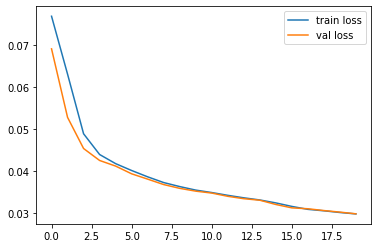

In [25]:
# Plot out the train loss and validation loss versus epochs

plt.plot(loss[0], label='train loss')
plt.plot(loss[1], label='val loss')
plt.legend()

# Deploy the model to testing dataset

In [33]:
# Prepare the testing dataset

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

# Input the test data into model and get the results
with torch.no_grad():
  test_examples, reconstruction = [], []
  for batch_features in test_loader:
      a = batch_features[0]
      input_ = a.view(-1, 784)
      input_ = input_.to(device)
      output_ = model(input_)
      output_ = output_.to(device)
      
      for n in range(len(input_)):
          test_examples.append(input_[n].to('cpu'))
          reconstruction.append(output_[n].to('cpu'))

# Create the reconstruction error array
err_arr = []
for i in range(len(test_examples)):
  err_arr.append(F.mse_loss(test_examples[i], reconstruction[i]))

err_arr = np.array(err_arr)

# Get the reconstructed images and original test images

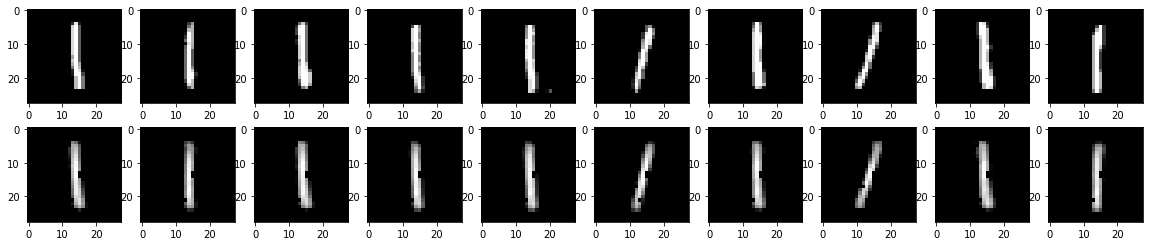

In [34]:
# 10 images with lowest reconstruction error

plt.figure(figsize=(20, 4))

for n, index in enumerate(np.argsort(err_arr)[:10]):
    ax = plt.subplot(2, 10, n+1)
    ax.imshow(test_examples[index].numpy().reshape(28, 28), cmap = 'gray')

    ax = plt.subplot(2, 10, n+11)
    ax.imshow(reconstruction[index].numpy().reshape(28, 28), cmap = 'gray')

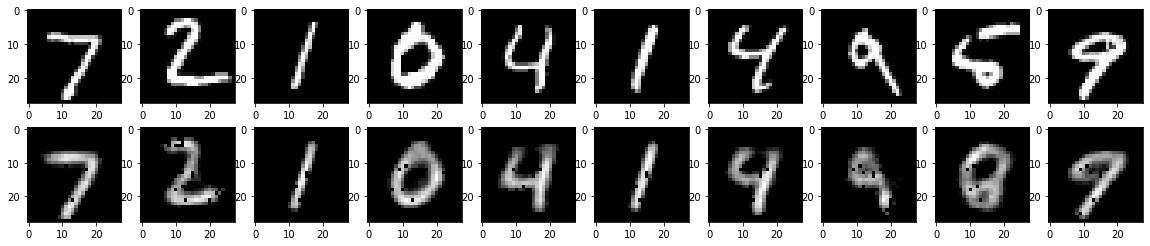

In [35]:
# 10 images with highest reconstruction error

plt.figure(figsize=(20, 4))

for index in range(10):
  ax = plt.subplot(2, 10, index+1)
  ax.imshow(test_examples[index].numpy().reshape(28, 28), cmap = 'gray')

  ax = plt.subplot(2, 10, index+11)
  ax.imshow(reconstruction[index].numpy().reshape(28, 28), cmap = 'gray')